<a href="https://colab.research.google.com/github/Rafinze/NeuralNetworkProjects/blob/main/Projeto4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo GRU
*Rafael Pires Moreira Silva - 163978*
• Implementar um modelo LSTM ou GRU para uma das tarefas abaixo:
1. Classificação de série temporais. O modelo deve receber uma janela
temporal (qualquer tipo de dado) e classificar o conteúdo da janela.
2. Previsão. Treinar um modelo para predizer o valor de uma variável no
instante t+k. O modelo deve receber os dados da série temporal
(instantes anteriores a t – verificar tamanho da janela) e predizer um
favor futuro. k a distância da predição. Por exemplo, podemos
alimentar um modelo com dados de uma dada empresa (i.e. PETR3) e
tentar predizer qual será o valor da ação daqui 5 dias (k==5)
3. Autoencoder recorrente. O modelo deve mapear a série temporal na
própria série. O objetivo será avaliar como os dados estão
representados no espaço latente


Neste trabalho, implementamos uma  rede neural recorrente, especificamente uma Gated Recurrent Unit (GRU), para classificar atividades humanas a partir de dados de sensores de smartphones. O objetivo é utilizar o dataset [UCI HAR](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) para treinar um modelo capaz de distinguir entre seis atividades diferentes: caminhar, subir escadas, descer escadas, sentar, ficar de pé e deitar.

Primeiramente, vamos realizar a importação das bibliotecas que serão utilizadas ao longo do projeto.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
import requests
import zipfile
import io
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")
sns.set_palette("viridis")

In [ ]:
def load_dataset_raw():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"

    print("Baixando o dataset...")
    response = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(response.content))
    print("Dataset baixado.")

    def load_file(filepath):
        return pd.read_csv(z.open(filepath), header=None, delim_whitespace=True).values

    signals_train = []
    signal_types = ['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z']

    for sig_type in signal_types:
        filepath = f'UCI HAR Dataset/train/Inertial Signals/{sig_type}_train.txt'
        signals_train.append(load_file(filepath))

    X_train = np.dstack(signals_train)

    signals_test = []
    for sig_type in signal_types:
        filepath = f'UCI HAR Dataset/test/Inertial Signals/{sig_type}_test.txt'
        signals_test.append(load_file(filepath))
    X_test = np.dstack(signals_test)

    y_train = load_file('UCI HAR Dataset/train/y_train.txt')
    y_test = load_file('UCI HAR Dataset/test/y_test.txt')

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset_raw()

Baixando o dataset...
Dataset baixado.


/tmp/ipython-input-2-1871696320.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(z.open(filepath), header=None, delim_whitespace=True).values
/tmp/ipython-input-2-1871696320.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(z.open(filepath), header=None, delim_whitespace=True).values
/tmp/ipython-input-2-1871696320.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(z.open(filepath), header=None, delim_whitespace=True).values
/tmp/ipython-input-2-1871696320.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(z.open(fi

### Bloco 3: Análise Exploratória dos Dados (EDA)

Antes de treinar o modelo, precisamos entender a distribuição dos dados. O gráfico abaixo mostra o número de amostras para cada atividade no conjunto de treino. Uma distribuição equilibrada, como a observada aqui, é ideal, pois evita que o modelo se torne tendencioso para as classes mais frequentes.

Formato dos dados de treino (X_train): (7352, 128, 9)
Formato dos rótulos de treino (y_train): (7352, 1)
Formato dos dados de teste (X_test): (2947, 128, 9)
Formato dos rótulos de teste (y_test): (2947, 1)


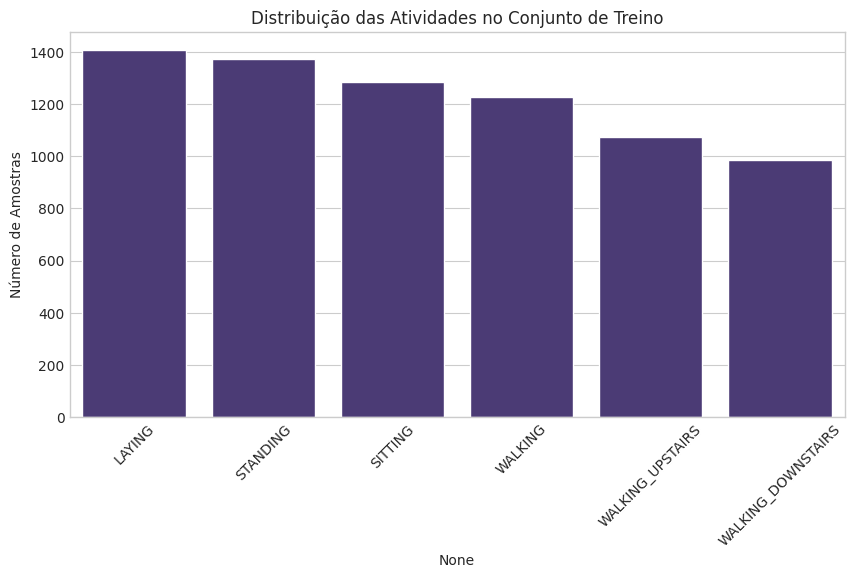

In [ ]:
print("Formato dos dados de treino (X_train):", X_train.shape)
print("Formato dos rótulos de treino (y_train):", y_train.shape)
print("Formato dos dados de teste (X_test):", X_test.shape)
print("Formato dos rótulos de teste (y_test):", y_test.shape)

activity_counts = pd.Series(y_train.flatten()).value_counts()
activity_labels = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}
activity_counts.index = activity_counts.index.map(activity_labels)

plt.figure(figsize=(10, 5))
sns.barplot(x=activity_counts.index, y=activity_counts.values)
plt.title('Distribuição das Atividades no Conjunto de Treino')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=45)
plt.show()

In [ ]:
y_train = y_train - 1
y_test = y_test - 1

n_classes = len(activity_labels)
y_train_hot = to_categorical(y_train, num_classes=n_classes)
y_test_hot = to_categorical(y_test, num_classes=n_classes)

print("Formato dos rótulos de treino após one-hot encoding:", y_train_hot.shape)
print("Exemplo de rótulo original:", y_train[0])
print("Exemplo de rótulo one-hot:", y_train_hot[0])

Formato dos rótulos de treino após one-hot encoding: (7352, 6)
Exemplo de rótulo original: [4]
Exemplo de rótulo one-hot: [0. 0. 0. 0. 1. 0.]


In [ ]:

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_classes = y_train_hot.shape[1]

model = Sequential([
    Input(shape=(n_timesteps, n_features)),
    GRU(units=100, return_sequences=True),
    Dropout(0.3),
    GRU(units=100),
    Dropout(0.3),
    Dense(units=100, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 128, 100)       │        33,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,606 (408.62 KB)

 Trainable params: 104,606 (408.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 552ms/step - accuracy: 0.4263 - loss: 1.3754 - val_accuracy: 0.5133 - val_loss: 1.1486
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 503ms/step - accuracy: 0.6095 - loss: 0.9183 - val_accuracy: 0.7403 - val_loss: 0.5846
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 80s 478ms/step - accuracy: 0.7979 - loss: 0.4606 - val_accuracy: 0.8783 - val_loss: 0.3685
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 478ms/step - accuracy: 0.8908 - loss: 0.2968 - val_accuracy: 0.9286 - val_loss: 0.2398
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 475ms/step - accuracy: 0.9449 - loss: 0.1516 - val_accuracy: 0.9259 - val_loss: 0.2208
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 592ms/step - accuracy: 0.9484 - loss: 0.1344 - val_accuracy: 0.8980 - val_loss: 0.2691
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 466ms/step - accuracy: 0.9432 - loss: 0.1410 - val_accuracy: 0.9300 - val_loss: 0.2611
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 474ms/step - accuracy: 0.9559 - loss: 0.1129 - val_accu

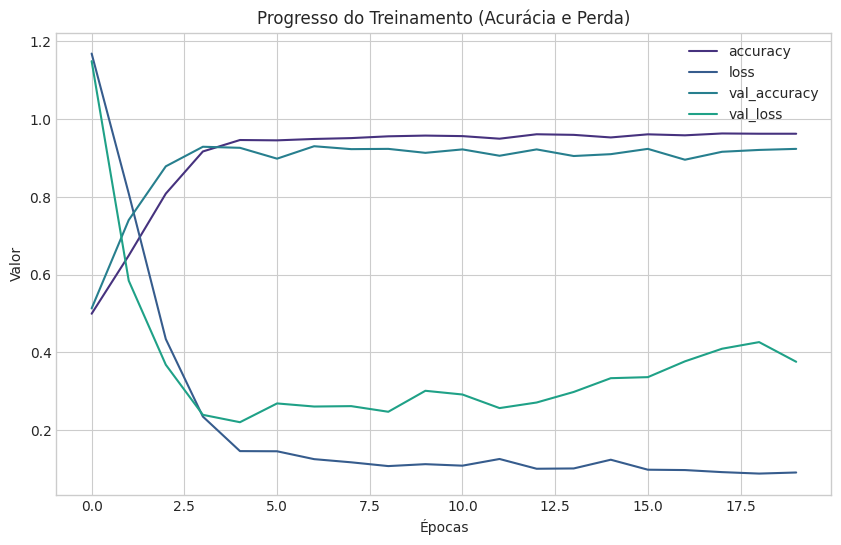

In [ ]:
epochs = 20
batch_size = 64

history = model.fit(
    X_train, y_train_hot,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2
)

pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.title("Progresso do Treinamento (Acurácia e Perda)")
plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

## Análise da Dinâmica de Treinamento

Pelo gráfico, podemos ver que o modelo GRU aprende de forma bastante eficaz. Nota-se uma convergência acentuada logo no início do processo, onde a acurácia de validação (`val_accuracy`) atinge rapidamente cerca de 90% nas primeiras 5 épocas, indicando uma assimilação veloz dos padrões fundamentais. Contudo, após essa fase inicial, a performance em validação tende a uma estabilização, oscilando entre 91% e 92%. Em paralelo, a perda de validação (`val_loss`) revela um ponto de inflexão: atinge seu valor mínimo, próximos de 20% por volta da 8ª época e, a partir daí, inicia uma trajetória ascendente.

Acurácia no conjunto de teste: 90.23%
Perda no conjunto de teste: 0.3613
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step


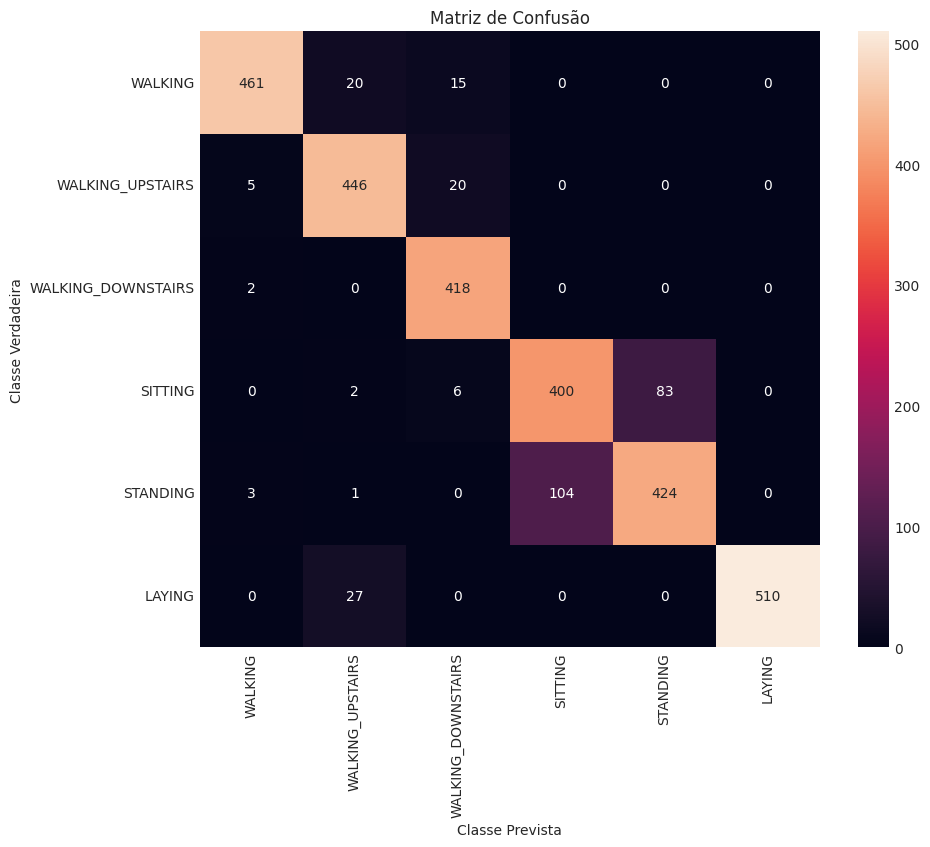


Relatório de Classificação:

                    precision    recall  f1-score   support

           WALKING       0.98      0.93      0.95       496
  WALKING_UPSTAIRS       0.90      0.95      0.92       471
WALKING_DOWNSTAIRS       0.91      1.00      0.95       420
           SITTING       0.79      0.81      0.80       491
          STANDING       0.84      0.80      0.82       532
            LAYING       1.00      0.95      0.97       537

          accuracy                           0.90      2947
         macro avg       0.90      0.91      0.90      2947
      weighted avg       0.90      0.90      0.90      2947



In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_hot, batch_size=batch_size, verbose=0)
print(f"Acurácia no conjunto de teste: {accuracy * 100:.2f}%")
print(f"Perda no conjunto de teste: {loss:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=activity_labels.values(),
            yticklabels=activity_labels.values())
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()

print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred, target_names=activity_labels.values()))

A matriz de confusão, gerada a partir do conjunto de teste, revela uma clara distinção na capacidade do modelo em classificar diferentes tipos de atividade. As atividades dinâmicas, como `WALKING, WALKING_UPSTAIRS` e `WALKING_DOWNSTAIRS`, formam agrupamentos de classificação quase perfeitos. A classe `WALKING`, por exemplo, foi corretamente identificada 461 vezes, com uma sobreposição mínima, sendo confundida 20 vezes com `WALKING_UPSTAIRS`. `WALKING_DOWNSTAIRS` apresenta um desempenho notável, com 418 acertos e apenas 2 confusões com a classe `WALKING`. Isso sugere que os padrões de sensores para esses movimentos são altamente distintos e foram aprendidos com sucesso.

Em contrapartida, a maior dificuldade do modelo reside na sobreposição entre as atividades estáticas `SITTING e STANDING`. Há uma confusão bidirecional significativa: 83 amostras de `SITTING` foram classificadas como STANDING, e 104 de STANDING foram classificadas como `SITTING`. Esta área de intersecção é esperada, dada a semelhança intrínseca dos sinais de sensores para essas duas posturas de baixa energia.

A classe LAYING, por sua vez, é a mais bem definida entre as estáticas, com 510 acertos e nenhuma confusão com `SITTING ou STANDING`. No entanto, é importante observar que a principal fonte de erro para esta classe foi a sua confusão com uma atividade dinâmica, sendo classificada incorretamente como `WALKING_UPSTAIRS` em 27 ocasiões.

O modelo GRU desenvolvido demonstrou ser uma solução robusta, alcançando alta precisão geral e, assim, validando as decisões de arquitetura e o método de pré-processamento de dados aplicado. O ponto forte desta implementação reside na sua notável capacidade de diferenciar atividades com características de movimento distintas. Isso é visível tanto na separação clara entre as categorias dinâmicas e estáticas, quanto na distinção de alta fidelidade entre as próprias atividades dinâmicas.

A principal limitação identificada, no entanto, é a sobreposição entre as classes `SITTING` e `STANDING`. Essa dificuldade revela que, embora o modelo seja poderoso, sua capacidade de generalização não é absoluta e diminui quando confrontado com a tarefa de separar amostras cujos padrões de sensores apresentam diferenças muito sutis. Portanto, conclui-se que o modelo aprendeu com sucesso as macro-características dos movimentos, mas ainda possui uma sensibilidade limitada às micro-variações que definem certas posturas estáticas.